# Comparing atlasqtl with M&M

In addition to [MTHESS](https://www.ncbi.nlm.nih.gov/pubmed/26504141) when we first conceived the project in 2016, two other papers from the same group of authors have been published with software implementation [locus](https://github.com/hruffieux/locus) ([paper](https://academic.oup.com/biostatistics/article/18/4/618/3072965)) and building on top of it, an efficient approach called [atlasqtl](https://github.com/hruffieux/atlasqtl) ([paper](https://arxiv.org/pdf/1811.03334.pdf)). `atlasqtl` approach is designed specifically for detecting pleiotropic patterns (which the authors refer to as "hotspots"). Here we challenge ourselves with a simulated example from `altlasqtl` documentation. 

## Conclusion
1. `atlasqtl` has no vignettes but has great documentation for function call `atlasqtl()`, the main function, with an example using simulated data.
2. `atlasqtl` is very fast for the scale of the problem with 50 responses; `mvsusieR` with naive MASH mixture in this case is a lot slower but still acceptable.
3. `mvsusieR` in this experiment uses naive MASH mixture that has uniform weight on >700 components. It can be made a lot faster (reducing number of components) and better (improving weights) when actual MASH approach is used.

Apart from computing time, on this particular example `mvsusieR` should still win: the PIP it reports is cleaner; and additioally it has the potential to give CS which is a feature from SuSiE model. Also we now support summary statistics which is useful for application in large GWAS studies.

## Setup

I copy the codes in ["example" section `atlasqtl` documentation](https://github.com/hruffieux/atlasqtl/blob/a7f76170d1c4a17bf743e22e16dc7631a76b7b17/man/atlasqtl.Rd#L141) to simulate N=500 samples, R=50 traits, P=2000 variables and L=10 causal variables (in their setting the setup was N=200, R=100, P=50 and L=10, but only 50 out of 100 traits have a genetic association).

In [1]:
seed = 1; set.seed(seed)
n <- 500; q = 50; p = 2000; p_act <- 10; q_act <- 50
X_act <- matrix(rbinom(n * p_act, size = 2, p = 0.25), nrow = n)
X_inact <- matrix(rbinom(n * (p - p_act), size = 2, p = 0.25), nrow = n)
shuff_x_ind <- sample(p)
shuff_y_ind <- sample(q)
X <- cbind(X_act, X_inact)[, shuff_x_ind]
dim(X)

[1]  500 2000

In [2]:
pat <- matrix(FALSE, ncol = q, nrow = p)
bool_x <- shuff_x_ind <= p_act
bool_y <- shuff_y_ind <= q_act
pat_act <- beta_act <- matrix(0, nrow = p_act, ncol = q_act)
pat_act[sample(p_act * q_act, floor(p_act * q_act / 5))] <- 1
beta_act[as.logical(pat_act)] <-  rnorm(sum(pat_act))
pat[bool_x, bool_y] <- pat_act
true_signal = which(rowSums(pat)>0)
true_signal

[1]   53  102  199  839  879 1318 1433 1682 1888 1966

In [3]:
dim(pat)

[1] 2000   50

In [4]:
Y_act <- matrix(rnorm(n * q_act, mean = X_act %*% beta_act), nrow = n)
Y_inact <- matrix(rnorm(n * (q - q_act)), nrow = n)
Y <- cbind(Y_act, Y_inact)[, shuff_y_ind]
dim(Y)

[1] 500  50

## Analysis with `atlasqtl`

Here I use all default `atlasqtl` setting including the assumption on number of effects to capture -- mean is 2, variance is 10.

In [5]:
# Number of effects to look for: mean is 2, variance is 10
p0 <- c(mean(colSums(pat)), 10)
p0

[1]  2 10

In [6]:
start_time <- Sys.time()
res_atlas <- atlasqtl::atlasqtl(Y = Y, X = X, p0 = p0, user_seed = seed)
end_time <- Sys.time()
end_time - start_time


== PREPROCESSING ... == 

== Checking the annealing schedule ... 

... done. == 

== Preparing the data ... 

... done. == 

== Preparing the hyperparameters ... 

list_hyper set automatically. 
... done. == 

== Preparing the parameter initialization ... 

Seed set to user_seed 1. 
list_init set automatically. 
... done. == 

**************************************************** 
Number of samples: 500
Number of (non-redundant) candidate predictors: 2000
Number of responses: 50
**************************************************** 

== ATLASQTL: fast global-local hotspot QTL detection == 

** Annealing with geometric spacing ** 

Iteration 1... 
Temperature = 2

Iteration 5... 
Temperature = 1.47

** Exiting annealing mode. **

Iteration 10... 
ELBO = -38243.23

Iteration 50... 
ELBO = -37916.66

Iteration 55... 
ELBO = -37914.47

Iteration 60... 
ELBO = -37912.53

Iteration 65... 
ELBO = -37910.79

Iteration 70... 
ELBO = -37909.23

Iteration 75... 
ELBO = -37907.84

Iteration 80... 


Time difference of 12.92161 secs

It takes **13 seconds** for the job! Memory usage for this computation is minimal (about 0.3GB).

# Analysis with `mvsusieR`

Prior effect size in `mvsusieR` is a required input. Here I use a naive MASH mixture prior -- using canonical covariances with scaled learned from data, and uniform weights,

In [7]:
X = X * 1.0
mash_prior = mvsusieR::create_mash_prior(sample_data = list(X=X,Y=Y, residual_variance=var(Y)), max_mixture_len=-1)

Now I fit M&M model. To be fair I allow for looking for up to 15 effects,

In [8]:
res_mvsusieR = mvsusieR::mvsusie(X,Y,L=15,prior_variance=mash_prior, precompute_covariances=TRUE)

In [9]:
res_mvsusieR$walltime

    user   system  elapsed 
1057.028    3.540 1061.214 

It takes **1061 seconds** to complete it. Memory usage for this case with `precompute_covariances` is about 1.5GB.

## Results

Again, the true signals are:

In [10]:
true_signal

[1]   53  102  199  839  879 1318 1433 1682 1888 1966

Cross-condition PIP for `atlasqtl` are:

In [17]:
atlpip = as.vector(1 - apply(1 - res_atlas$gam_vb, 1, prod))

Let's plot it with M&M's PIP,

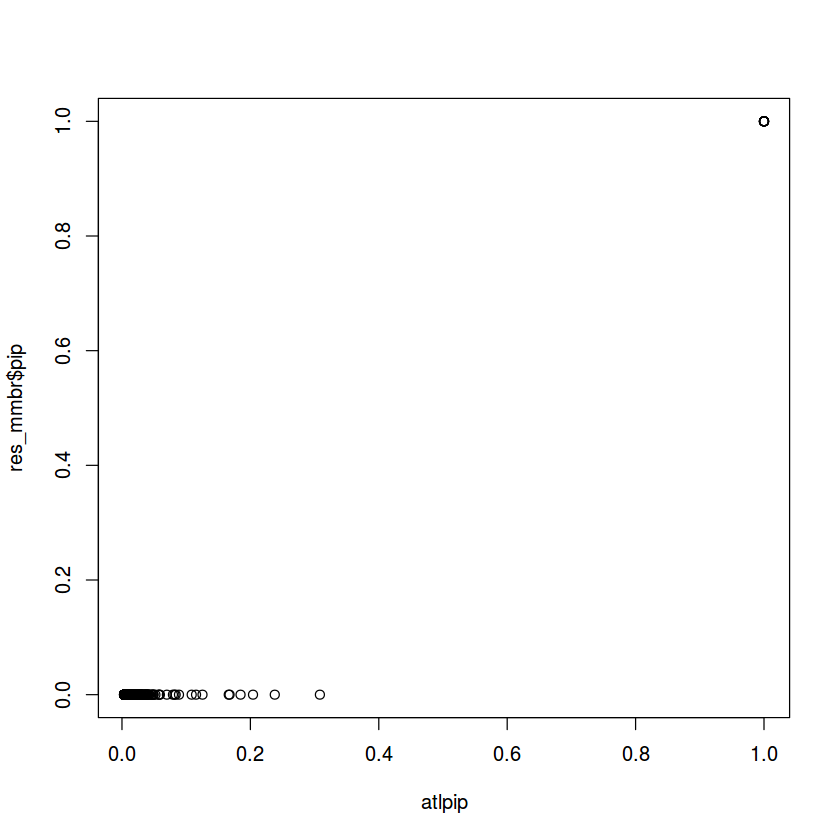

In [12]:
plot(atlpip, res_mvsusieR$pip)

Let's see how well both methods recover the true signals at PIP cutoff 0.9,

In [13]:
which(atlpip>0.9)

[1]   53  102  199  839  879 1318 1433 1682 1888 1966

In [14]:
which(res_mvsusieR$pip>0.9)

[1]   53  102  199  839  879 1318 1433 1682 1888 1966

It seems they both do good job in recovering all the simulated signals. But M&M's PIP are "cleaner". I have tried several different seeds and see this pattern consistently. I would expect in this setting we should do better in the precision recall curve. 

**Caveat: is my computation of atlasqtl's cross-condition PIP correct?** Here no filter is applied and different conditions are assumed independent ...

## A less naive MASH mixture to make M&M faster
Previously the naive MASH mixture contains many priors -- 771 of them,

In [10]:
length(mash_prior$prior_variance$xUlist)

[1] 771

Now I'll focus on only using the non-singleton priors, reducing it to 71:

In [12]:
mash_prior_shared = mvsusieR::create_mash_prior(sample_data = list(X=X,Y=Y, residual_variance=var(Y)), max_mixture_len=-1, singletons=F)

In [13]:
length(mash_prior_shared$prior_variance$xUlist)

[1] 71

Let's time the run with this prior,

In [14]:
res_mvsusie_shared = mvsusieR::mvsusie(X,Y,L=15,prior_variance=mash_prior_shared, precompute_covariances=TRUE)

In [15]:
res_mvsusie_shared$walltime

   user  system elapsed 
170.472   4.972 175.557 

It is **now 175 seconds**.